In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Downsample all platforms to have the same number of data points


In [64]:
df = pd.read_csv('full_dataset.csv')
df.platform.value_counts()

twitter      488167
reddit        72135
instagram     15652
youtube       11304
Name: platform, dtype: int64

In [65]:
df['positivity_normalized'] = (df.positive_words - df.negative_words)/df.word_count
df['intensity_normalized'] = (df.positive_words + df.negative_words)/df.word_count

In [66]:
df = df.dropna()

In [69]:
df_twitter = df.loc[df.platform=='twitter'].sample(11303)
df_reddit = df.loc[df.platform=='reddit'].sample(11303)
df_youtube = df.loc[df.platform=='youtube']
df_instagram = df.loc[df.platform=='instagram'].sample(11303)

In [70]:
df_small = pd.concat([df_twitter, df_reddit, df_youtube, df_instagram])

In [71]:
from sklearn.model_selection import train_test_split

In [83]:
df_train, df_test = train_test_split(df_small.copy(), 
                                     shuffle=True, 
                                     test_size=.2, 
                                     random_state=404,
                                    stratify=df_small.platform)

df_test.platform.value_counts()

youtube      2261
instagram    2261
twitter      2261
reddit       2260
Name: platform, dtype: int64

In [84]:
df_train.to_csv('small_train_dataset.csv')
df_test.to_csv('small_test_dataset.csv')

Positivity is the positive_words and negative_words balance.
Intensity is the sum of pos and neg

,Unnamed: 0,text,platform,positive_words,negative_words,length,word_count,male_words,female_words,afinn,positivity_normalized,intensity_normalized
531834,531834,Grandpa?,reddit,0,0,8,1,0,0,0.0,0.000,0.000000
325553,325553,The sooner we as an Ummah live in accordance t...,twitter,0,0,115,23,0,0,2.0,0.000,0.000000
530669,530669,High school? College?,reddit,0,0,21,3,0,0,0.0,0.000,0.000000
580659,580659,Damn I love this song and this music video,youtube,1,1,42,9,0,0,1.0,0.000,0.222222
576082,576082,He is so messy with the spices lol,youtube,0,1,34,8,2,0,3.0,-0.125,0.125000


# Single feature logistic regression


In [12]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [135]:
df_train = pd.read_csv('small_train_dataset.csv')
df_test = pd.read_csv('small_test_dataset.csv')

n_splits = 5
kfold = StratifiedKFold(n_splits, shuffle=True, random_state = 404)
features = ['word_count', 'afinn', 'positivity_normalized', 'intensity_normalized', 'male_words', 'female_words']

## Make your array of zeros to hold the accuracies
log_reg_accs = np.zeros((n_splits, len(features)))

In [136]:
## Loop through the cv splits
i = 0
for train_index, test_index in kfold.split(df_train,df_train.platform):
    ## get the training and holdout sets
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    
    ## loop through your features
    j = 0
    for feature in features:
        ## Define the model
        log_reg = LogisticRegression(penalty='none')
        
        ## fit the model
        log_reg = log_reg.fit(df_tt[feature].values.reshape(-1, 1), df_tt['platform'].values)
        
        ## Make the prediction
        pred = log_reg.predict(df_ho[feature].values.reshape(-1, 1))
        
        ## Record the accuracy on the holdout set
        log_reg_accs[i,j] = accuracy_score(df_ho['platform'].values, pred)
        print(confusion_matrix(df_ho['platform'].values, pred, labels=["instagram", "twitter", "reddit", "youtube"]))
        j = j + 1
    i = i + 1
    
np.mean(log_reg_accs, axis=0)
print(log_reg_accs)

[[  75   80 1342  312]
 [ 180  144  754  731]
 [ 192  183 1101  332]
 [ 130  101 1019  558]]
[[ 558 1183    0   68]
 [ 544 1126    0  139]
 [ 557 1118    0  133]
 [ 623 1057    0  128]]
[[ 490 1294   12   13]
 [ 473 1335    0    1]
 [ 462 1345    0    1]
 [ 480 1292   10   26]]
[[ 546    5 1234   24]
 [ 640    2 1146   21]
 [ 579    1 1193   35]
 [ 615    1 1170   22]]
[[   0    0 1700  109]
 [   0    0 1717   92]
 [   0    0 1737   71]
 [   0    0 1642  166]]
[[  95    0 1714    0]
 [  72    0 1737    0]
 [  43    0 1765    0]
 [  51    0 1757    0]]
[[ 111   61 1289  348]
 [ 168  146  765  730]
 [ 197  192 1093  326]
 [ 170   90 1006  542]]
[[ 608 1127    0   74]
 [ 551 1121    0  137]
 [ 564 1114    0  130]
 [ 606 1086    0  116]]
[[ 568 1221   12    8]
 [ 513 1296    0    0]
 [ 442 1366    0    0]
 [ 478 1295   20   15]]
[[ 575    2 1218   14]
 [ 667    2 1108   32]
 [ 587    0 1191   30]
 [ 609    3 1169   27]]
[[   0    0 1704  105]
 [   0    0 1687  122]
 [   0    0 1727   81]
 

array([0.26638837, 0.25085021, 0.25731986, 0.24686893, 0.26265593,
       0.25748572])

# Findings
Original full dataset:

Here we are fitting logistic regression using word_count, afinn, positivity and instensity individually. 
The confusion matrix has true labels on the rows, prediction on the columns. 
Most model just predict all points as twitter. 
The accuracy was high but the model itself is a trivial one. 
It will not generate well. 

We may need to use balance the dataset by undersample twitter data. 

small dataset: 

accuracy for each featuer decrease to about 26%

# Combined logistic regression

In [4]:
from sklearn import preprocessing

In [19]:
features = ['word_count', 'afinn', 'positivity_normalized', 'intensity_normalized', 'male_words', 'female_words']
df_train = pd.read_csv('small_train_dataset.csv')
df_test = pd.read_csv('small_test_dataset.csv')

n_splits = 5
kfold = StratifiedKFold(n_splits, shuffle=True, random_state = 404)

## Make your array of zeros to hold the accuracies
log_reg_accs = np.zeros((n_splits, 1))

In [20]:
scaler = preprocessing.StandardScaler().fit(df_train[features])
df_train_scaled = scaler.transform(df_train[features])

In [21]:
data = {'word_count': df_train_scaled[:, 0],
         'afinn': df_train_scaled[:, 1],
         'positivity_normalized': df_train_scaled[:, 2],
         'intensity_normalized': df_train_scaled[:, 3],
        'male_words': df_train_scaled[:, 4],
        'female_words': df_train_scaled[:, 5],
         'platform': df_train.platform}
df_train = pd.DataFrame(data)

In [22]:
i = 0
for train_index, test_index in kfold.split(df_train, df_train.platform):
    ## get the training and holdout sets

    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    
    ## Define the model
    log_reg = LogisticRegression(penalty='none')
        
    ## fit the model
    log_reg = log_reg.fit(df_tt[features].values, df_tt.platform.values)
        
    ## Make the prediction
    pred = log_reg.predict(df_ho[features].values)
    ## Record the accuracy on the holdout set
    log_reg_accs[i,0] = accuracy_score(df_ho.platform, pred)
    print(confusion_matrix(df_ho.platform, pred, labels=["instagram", "twitter", "reddit", "youtube"]))

    i = i + 1
    
np.mean(log_reg_accs, axis=0)

[[442 184 997 186]
 [400 638 542 229]
 [441 427 823 117]
 [405 341 704 358]]
[[483 158 952 216]
 [401 616 506 286]
 [433 457 790 128]
 [390 358 708 352]]
[[464 210 961 173]
 [422 601 505 280]
 [453 439 801 116]
 [448 367 654 340]]
[[441 198 930 239]
 [397 622 516 273]
 [436 412 844 117]
 [372 414 702 321]]
[[481 164 967 196]
 [399 621 499 289]
 [494 383 828 104]
 [398 385 670 355]]


array([0.31023821])

# Repeat all feature model with all training data, test on test data
- make scaler with training data
- scale both train and test data 
- train model on train data
- predict on test data and plot confusion matrix. 


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

features = ['word_count', 'afinn', 'positivity_normalized', 'intensity_normalized', 'male_words', 'female_words']
df_train = pd.read_csv('small_train_dataset.csv')
df_test = pd.read_csv('small_test_dataset.csv')

scaled_train = df_train.copy()
feature_data = scaled_train[features]
scaler = StandardScaler().fit(feature_data.values)
feature_data = scaler.transform(feature_data.values)
scaled_train[features] = feature_data

scaled_test = df_test.copy()
test_data = scaler.transform(scaled_test[features].values)
scaled_test[features] = test_data


,Unnamed: 0,Unnamed: 0.1,text,platform,positive_words,negative_words,length,word_count,male_words,female_words,afinn,positivity_normalized,intensity_normalized
0,261334,261334,don't worry someone will get you,twitter,0,1,34,6,0,0,-3.0,-0.166667,0.166667
1,519687,519687,Let me provide some thing for yoooou.,reddit,0,0,37,7,0,0,0.0,0.000000,0.000000
2,504903,504903,Most Kanye music and nearly all rap music but ...,reddit,0,1,85,17,0,0,-3.0,-0.058824,0.058824
3,500180,500180,Know who you really are not what people tell y...,instagram,0,0,59,12,0,0,0.0,0.000000,0.000000
4,493549,493549,Runway.,instagram,0,0,8,1,0,0,0.0,0.000000,0.000000


[[ 599  252 1178  232]
 [ 492  840  601  328]
 [ 573  515 1021  151]
 [ 461  501  880  419]]
accuracy:  0.31836779829702533


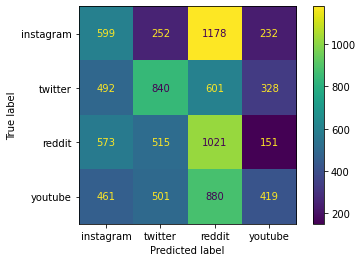

In [42]:

## Define the model
log_reg = LogisticRegression(penalty='none')

## fit the model
log_reg = log_reg.fit(scaled_train[features].values, scaled_train.platform.values)

## Make the prediction
pred = log_reg.predict(scaled_test[features].values)
## Record the accuracy on the holdout set
log_reg_accs = accuracy_score(scaled_test.platform, pred)
confusion_mat = confusion_matrix(scaled_test.platform, pred, labels=["instagram", "twitter", "reddit", "youtube"])
print(confusion_mat)
print('accuracy: ', log_reg_accs)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels=["instagram", "twitter", "reddit", "youtube"])
cm_display.plot()
plt.savefig('fourgroup_logreg.png', dpi=300)
plt.show()

# Two class classifier 

Instead of trying to classify them into the 4 bins, train model to try to distinguish one platform from the other three. 

First create one hot encoding for each platform, then add two together to make two-platform bins.


In [6]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [7]:
df_train = pd.read_csv('small_train_dataset.csv')
df_test = pd.read_csv('small_test_dataset.csv')

In [8]:
# scaled the numerical data
features = ['word_count', 'afinn', 'positivity_normalized', 'intensity_normalized', 'male_words', 'female_words']
scaler = preprocessing.StandardScaler().fit(df_train[features])
df_train_scaled = scaler.transform(df_train[features])
data = {'word_count': df_train_scaled[:, 0],
         'afinn': df_train_scaled[:, 1],
         'positivity_normalized': df_train_scaled[:, 2],
         'intensity_normalized': df_train_scaled[:, 3],
        'male_words': df_train_scaled[:, 4],
        'female_words': df_train_scaled[:, 5],
         'platform': df_train.platform}
df_train = pd.DataFrame(data)

# create one hot encoding
df_train['dum_twitter'] = 0
df_train.loc[df_train.platform=='twitter', 'dum_twitter'] = 1
df_train['dum_reddit'] = 0
df_train.loc[df_train.platform=='reddit', 'dum_reddit'] = 1
df_train['dum_instagram'] = 0
df_train.loc[df_train.platform=='instagram', 'dum_instagram'] = 1
df_train['dum_youtube'] = 0
df_train.loc[df_train.platform=='youtube', 'dum_youtube'] = 1

df_train['dum_twigram'] = df_train.dum_twitter + df_train.dum_instagram
df_train['dum_twiddit'] = df_train.dum_twitter + df_train.dum_reddit
df_train['dum_twitube'] = df_train.dum_twitter + df_train.dum_youtube

df_train.head()


,word_count,afinn,positivity_normalized,intensity_normalized,male_words,female_words,platform,dum_twitter,dum_reddit,dum_instagram,dum_youtube,dum_twigram,dum_twiddit,dum_twitube
0,-0.282820,-1.284547,-1.414830,0.719725,-0.214425,-0.165903,twitter,1,0,0,0,1,1,1
1,-0.230636,-0.294327,-0.181968,-0.596013,-0.214425,-0.165903,reddit,0,1,0,0,0,1,0
2,0.291204,-1.284547,-0.617096,-0.131635,-0.214425,-0.165903,reddit,0,1,0,0,0,1,0
3,0.030284,-0.294327,-0.181968,-0.596013,-0.214425,-0.165903,instagram,0,0,1,0,1,0,0
4,-0.543739,-0.294327,-0.181968,-0.596013,-0.214425,-0.165903,instagram,0,0,1,0,1,0,0


In [14]:
n_splits = 5
kfold = StratifiedKFold(n_splits, shuffle=True, random_state = 404)

dums = ['dum_instagram', 'dum_twitter', 'dum_reddit', 'dum_youtube',
        'dum_twigram', 'dum_twiddit', 'dum_twitube']
log_reg_accs = np.zeros([5, len(dums)])
recall = np.zeros([5, len(dums)])
j = 0
for feature in dums:
    i = 0
    for train_index, test_index in kfold.split(df_train, df_train[feature]):
        ## get the training and holdout sets

        df_tt = df_train.iloc[train_index]
        df_ho = df_train.iloc[test_index]

        ## Define the model
        log_reg = LogisticRegression(penalty='none')

        ## fit the model
        log_reg = log_reg.fit(df_tt[features].values, df_tt[feature].values)

        ## Make the prediction
        pred = log_reg.predict(df_ho[features].values)
        ## Record the accuracy on the holdout set
        log_reg_accs[i,j] = accuracy_score(df_ho[feature], pred)
        conf = confusion_matrix(df_ho[feature], pred)
        TN = conf[0,0]
        FP = conf[0,1]
        FN = conf[1,0]
        TP = conf[1,1]
        #print('recall: ', TP/(TP + FN))
        recall[i, j] = TP/(TP + FN)

        i = i + 1
    j += 1
    
#print(log_reg_accs)

In [15]:
print(np.mean(log_reg_accs, axis=0))
print(np.mean(recall,axis=0))

[0.75033869 0.74909454 0.74997927 0.75321409 0.49860373 0.5218005
 0.59697539]
[5.08733373e-03 1.10619469e-04 0.00000000e+00 2.42199157e-02
 2.96671064e-01 6.43903788e-01 4.87115340e-01]


Since twitube vs redgram is the highest accuracy case, run single feature regression to see which one contributed the most. 

In [18]:
features = ['word_count', 'afinn', 'positivity_normalized', 'intensity_normalized', 'male_words', 'female_words']

log_reg_accs = np.zeros([5, len(features)])
recall = np.zeros([5, len(features)])
j = 0
for feature in features:
    i = 0
    for train_index, test_index in kfold.split(df_train, df_train['dum_twitube']):
        ## get the training and holdout sets

        df_tt = df_train.iloc[train_index]
        df_ho = df_train.iloc[test_index]

        ## Define the model
        log_reg = LogisticRegression(penalty='none')

        ## fit the model
        log_reg = log_reg.fit(df_tt[feature].values.reshape(-1, 1), df_tt['dum_twitube'].values)

        ## Make the prediction
        pred = log_reg.predict(df_ho[feature].values.reshape(-1, 1))
        ## Record the accuracy on the holdout set
        log_reg_accs[i,j] = accuracy_score(df_ho['dum_twitube'], pred)
        conf = confusion_matrix(df_ho['dum_twitube'], pred)
        print(conf)
        TN = conf[0,0]
        FP = conf[0,1]
        FN = conf[1,0]
        TP = conf[1,1]
        #print('recall: ', TP/(TP + FN))
        recall[i, j] = TP/(TP + FN)

        i = i + 1
    j += 1
    

[[2611 1006]
 [1964 1653]]
[[2621  996]
 [1914 1703]]
[[2575 1042]
 [1919 1698]]
[[2551 1066]
 [1906 1711]]
[[2622  995]
 [1892 1724]]
[[1335 2282]
 [1425 2192]]
[[1324 2293]
 [1408 2209]]
[[1336 2281]
 [1442 2175]]
[[1381 2236]
 [1422 2195]]
[[1328 2289]
 [1378 2238]]
[[1009 2608]
 [ 962 2655]]
[[ 983 2634]
 [ 971 2646]]
[[ 997 2620]
 [1027 2590]]
[[1028 2589]
 [1022 2595]]
[[ 990 2627]
 [1005 2611]]
[[2421 1196]
 [2362 1255]]
[[1252 2365]
 [1398 2219]]
[[1217 2400]
 [1376 2241]]
[[2398 1219]
 [2301 1316]]
[[2420 1197]
 [2293 1323]]
[[3448  169]
 [3360  257]]
[[3418  199]
 [3319  298]]
[[3447  170]
 [3350  267]]
[[3433  184]
 [3355  262]]
[[3446  171]
 [3358  258]]
[[3494  123]
 [3489  128]]
[[3504  113]
 [3479  138]]
[[3470  147]
 [3484  133]]
[[3470  147]
 [3484  133]]
[[ 118 3499]
 [ 142 3474]]


In [17]:
print(np.mean(log_reg_accs, axis=0))
print(np.mean(recall,axis=0))

[0.59357481 0.48972886 0.50053906 0.49937842 0.51242776 0.49937784]
[0.46942089 0.60877074 0.72423125 0.46195001 0.07420909 0.22156266]


# Repeat two class classifier on train test data

In [46]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [47]:
features = ['word_count', 'afinn', 'positivity_normalized', 'intensity_normalized', 'male_words', 'female_words']
df_train = pd.read_csv('small_train_dataset.csv')
df_test = pd.read_csv('small_test_dataset.csv')

scaled_train = df_train.copy()
feature_data = scaled_train[features]
scaler = StandardScaler().fit(feature_data.values)
feature_data = scaler.transform(feature_data.values)
scaled_train[features] = feature_data

scaled_test = df_test.copy()
test_data = scaler.transform(scaled_test[features].values)
scaled_test[features] = test_data

# create one hot encoding
scaled_train['dum_twitter'] = 0
scaled_train.loc[scaled_train.platform=='twitter', 'dum_twitter'] = 1
scaled_train['dum_reddit'] = 0
scaled_train.loc[scaled_train.platform=='reddit', 'dum_reddit'] = 1
scaled_train['dum_instagram'] = 0
scaled_train.loc[scaled_train.platform=='instagram', 'dum_instagram'] = 1
scaled_train['dum_youtube'] = 0
scaled_train.loc[scaled_train.platform=='youtube', 'dum_youtube'] = 1

scaled_train['dum_twigram'] = scaled_train.dum_twitter + scaled_train.dum_instagram
scaled_train['dum_twiddit'] = scaled_train.dum_twitter + scaled_train.dum_reddit
scaled_train['dum_twitube'] = scaled_train.dum_twitter + scaled_train.dum_youtube


# create one hot encoding
scaled_test['dum_twitter'] = 0
scaled_test.loc[scaled_test.platform=='twitter', 'dum_twitter'] = 1
scaled_test['dum_reddit'] = 0
scaled_test.loc[scaled_test.platform=='reddit', 'dum_reddit'] = 1
scaled_test['dum_instagram'] = 0
scaled_test.loc[scaled_test.platform=='instagram', 'dum_instagram'] = 1
scaled_test['dum_youtube'] = 0
scaled_test.loc[scaled_test.platform=='youtube', 'dum_youtube'] = 1

scaled_test['dum_twigram'] = scaled_test.dum_twitter + scaled_test.dum_instagram
scaled_test['dum_twiddit'] = scaled_test.dum_twitter + scaled_test.dum_reddit
scaled_test['dum_twitube'] = scaled_test.dum_twitter + scaled_test.dum_youtube


[[3200 1321]
 [2277 2245]]
accuracy:  0.6021231892071215


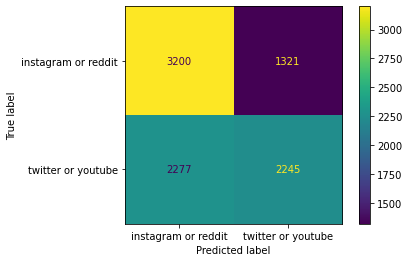

In [50]:

## Define the model
log_reg = LogisticRegression(penalty='none')

## fit the model
log_reg = log_reg.fit(scaled_train[features].values, scaled_train.dum_twitube.values)

## Make the prediction
pred = log_reg.predict(scaled_test[features].values)
## Record the accuracy on the holdout set
log_reg_accs = accuracy_score(scaled_test.dum_twitube, pred)
confusion_mat = confusion_matrix(scaled_test.dum_twitube, pred)
print(confusion_mat)
print('accuracy: ', log_reg_accs)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat, display_labels=["instagram or reddit", "twitter or youtube"])
cm_display.plot()
plt.savefig('twogroup_logreg.png', dpi=300)
plt.show()

In [55]:
features = ['word_count', 'afinn', 'positivity_normalized', 'intensity_normalized', 'male_words', 'female_words']

acc = np.zeros([6, 1])
i = 0
for feature in features:
    ## Define the model
    log_reg = LogisticRegression(penalty='none')

    ## fit the model
    log_reg = log_reg.fit(scaled_train[feature].values.reshape(-1, 1), scaled_train.dum_twitube.values)

    ## Make the prediction
    pred = log_reg.predict(scaled_test[feature].values.reshape(-1, 1))
    ## Record the accuracy on the holdout set
    acc[i] = accuracy_score(scaled_test.dum_twitube, pred)
    
    i += 1
    
print(acc)

[[0.59460356]
 [0.49673781]
 [0.5058056 ]
 [0.51664271]
 [0.51332522]
 [0.5019352 ]]


# Conclusions
Using all features, model was able to tell twitube from redgram with ~60% accuracy. 
